In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from lifelines.utils import k_fold_cross_validation, median_survival_times
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter, NelsonAalenFitter,\
                      CoxPHFitter, WeibullAFTFitter, WeibullFitter, ExponentialFitter,\
                      LogNormalFitter, LogLogisticFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.plotting import plot_lifetimes
# define filepath to read data
dir_path = '../Data/CMaps/'
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names
# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['time_cycles'])
# inspect first few rows
train.head()
type(y_test)

pandas.core.frame.DataFrame

In [17]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
print(train.shape)
train[index_names+['RUL']].head()

(20631, 27)


,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [18]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)  

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']  
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

(20631, 17)

In [19]:
train['breakdown'] = 0
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1
train['start'] = train['time_cycles'] - 1 
train.tail() # check results

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1,199


In [20]:
# cut off is the censoring cycle time line
cut_off = 200
train_censored = train[train['time_cycles'] <= cut_off].copy()
print(train_censored.shape)
train_censored[train_censored["unit_nr"] == 50].tail()

(18627, 19)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
9904,50,194,643.77,1604.93,1423.51,551.41,2388.18,9128.75,48.16,519.85,2388.19,8194.20,8.5043,396,38.42,23.0543,4,0,193
9905,50,195,643.33,1605.31,1434.87,551.25,2388.17,9134.70,48.14,519.33,2388.21,8200.90,8.5352,395,38.45,23.0191,3,0,194
9906,50,196,643.32,1602.26,1430.01,551.40,2388.19,9129.59,48.24,519.88,2388.17,8194.10,8.5034,395,38.45,23.0379,2,0,195
9907,50,197,643.73,1599.94,1432.87,551.18,2388.19,9132.97,48.22,519.48,2388.20,8194.64,8.5241,397,38.52,23.0832,1,0,196
9908,50,198,643.83,1608.20,1433.88,552.06,2388.20,9128.91,48.01,520.00,2388.25,8200.20,8.5002,396,38.43,23.1086,0,1,197


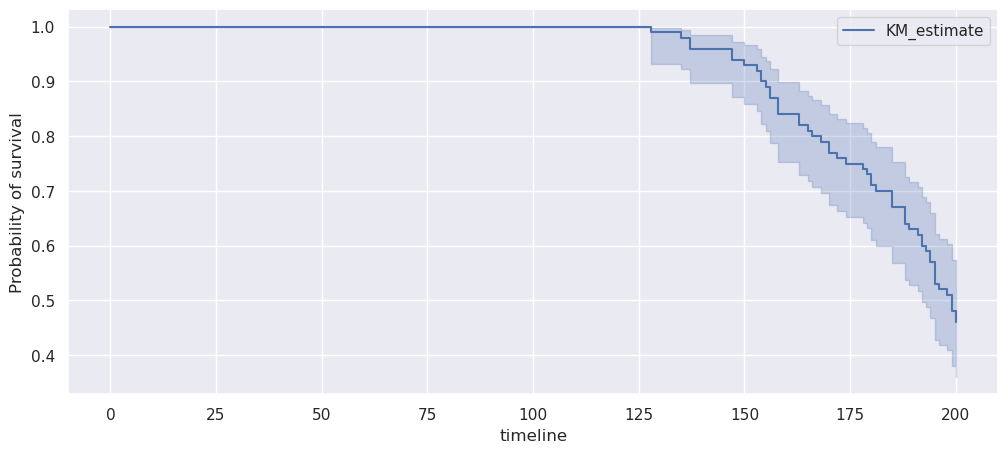

,time_cycles,breakdown
unit_nr,,
96,200,0
97,200,0
98,156,1
99,185,1
100,200,1


In [21]:
data = train_censored[index_names+['breakdown']].groupby('unit_nr').last()
plt.figure(figsize=(12,5))
survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()
plt.ylabel("Probability of survival")
plt.show()
plt.close()
data.tail()

<AxesSubplot:xlabel='timeline'>

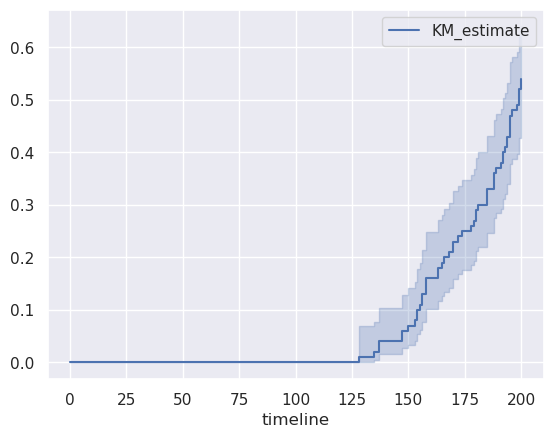

In [22]:
survival.plot_cumulative_density()

In [23]:
median_ = survival.median_survival_time_
median_confidence_interval_ = median_survival_times(survival.confidence_interval_)
print(median_)
print(median_confidence_interval_)

199.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   192.0                     inf


<AxesSubplot:xlabel='timeline'>

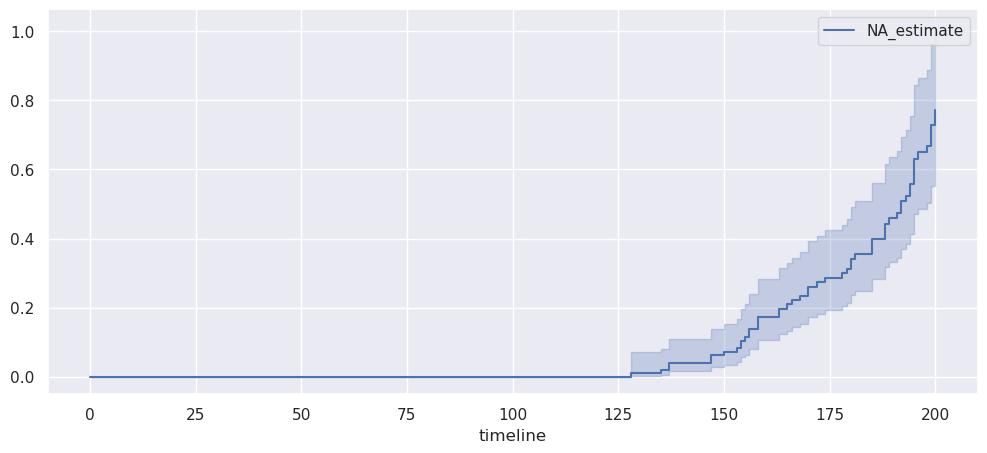

In [24]:
naf = NelsonAalenFitter()
naf.fit(data['time_cycles'], data['breakdown'])
plt.figure(figsize=(12,5))
naf.plot()

<AxesSubplot:>

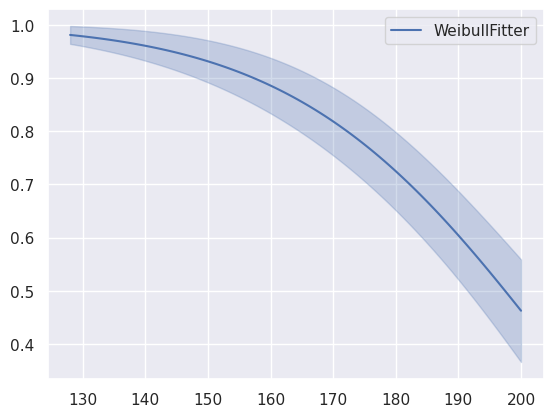

In [25]:
wbf = WeibullFitter().fit(data['time_cycles'], data['breakdown'], label='WeibullFitter')
wbf.plot_survival_function()

In [26]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(train_censored[train_cols], id_col="unit_nr", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=True)

Iteration 1: norm_delta = 0.12570, step_size = 0.95000, ll = -230.78680, newton_decrement = 20.22193, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00674, step_size = 0.95000, ll = -210.58504, newton_decrement = 0.05757, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00034, step_size = 0.95000, ll = -210.52760, newton_decrement = 0.00015, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00002, step_size = 1.00000, ll = -210.52745, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -210.52745, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
         penalizer = 0.1
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -210.53
  time fit was run = 2023-05-16 16:21:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
s_2         0.07       1.07       0.05            -0.02             0.17                 0.98                 1.18
s_3         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
s_4         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
s_7        -0.05       0.95       0.03            -0.10             0.01                 0.90                 1.01
s_8         0.53       1.70       0.33            -0.13             1.18                 0.88                 3.27
s_9         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
s_11        0.17       1.18       0.09            -0.01             0.35                 0.99                 1.41
s_12       -0.06       0.94       0.03            -0.12             0.01                 0.88                 1.01
s_13        0.55       1.73       0.33            -0.10             1.20                 0.91                 3.30
s_14        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
s_15        1.09       2.97       0.65            -0.19             2.36                 0.83                10.60
s_17        0.02       1.02       0.02            -0.01             0.05                 0.99                 1.06
s_20       -0.23       0.79       0.13            -0.50             0.03                 0.61                 1.03
s_21       -0.36       0.70       0.22            -0.80             0.08                 0.45                 1.09

            cmp to     z    p   -log2(p)
covariate                               
s_2           0.00  1.46 0.14       2.80
s_3           0.00  1.43 0.15       2.72
s_4           0.00  1.91 0.06       4.15
s_7           0.00 -1.73 0.08       3.57
s_8           0.00  1.58 0.11       3.14
s_9           0.00  0.72 0.47       1.08
s_11          0.00  1.81 0.07       3.83
s_12          0.00 -1.76 0.08       3.66
s_13          0.00  1.67 0.10       3.39
s_14          0.00  0.47 0.64       0.65
s_15          0.00  1.67 0.09       3.40
s_17          0.00  1.47 0.14       2.82
s_20          0.00 -1.75 0.08       3.63
s_21          0.00 -1.58 0.11       3.14
---
Partial AIC = 449.05
log-likelihood ratio test = 40.52 on 14 df
-log2(p) of ll-ratio test = 12.21

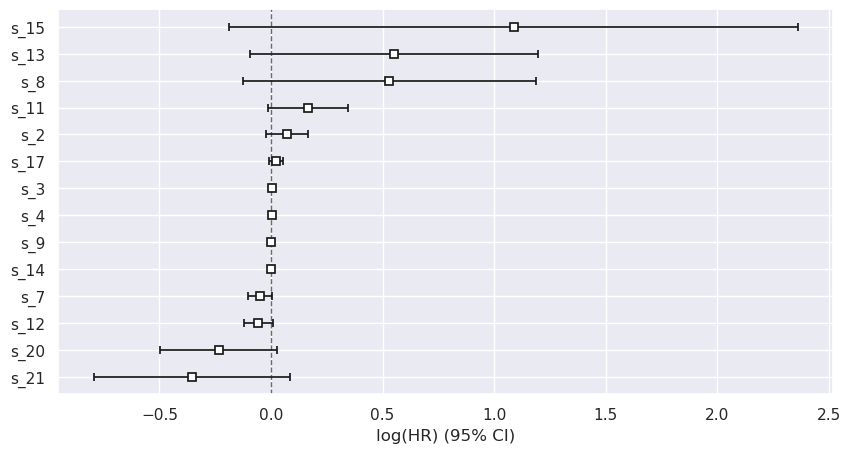

In [27]:
ctv.print_summary()
plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [28]:
# get the last unit time series data frame
df = train_censored.groupby("unit_nr").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df.copy().reset_index()
# predictions = pd.DataFrame(ctv.predict_log_partial_hazard(df_to_predict[predict_cols]), index=df_to_predict.index)
predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols]).to_frame()
predictions.rename(columns={0: "predictions"}, inplace=True)
df_last = train.groupby('unit_nr').last()
predictions['RUL'] = df_to_predict['RUL']
predictions.head(10)

,predictions,RUL
0,-0.086898,87
1,-0.099888,69
2,0.197106,59
3,1.373235,1
4,0.650010,22
5,0.255813,40
6,0.791317,7
7,1.080026,9
8,-0.151703,76
9,0.548900,34


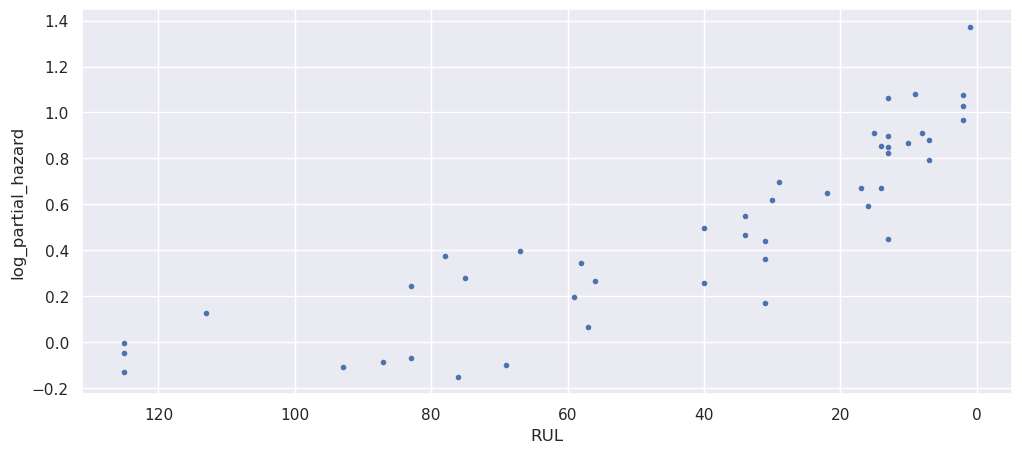

In [29]:
plt.figure(figsize=(12,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')
plt.show()

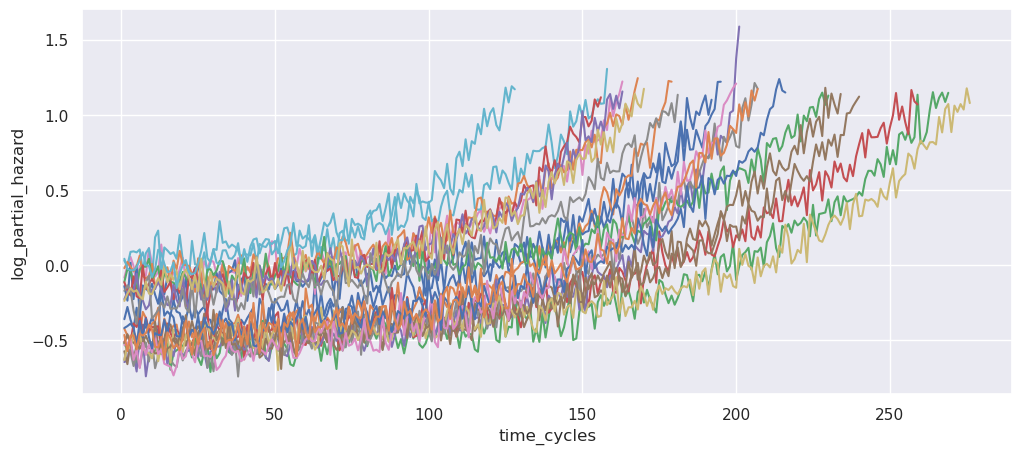

In [30]:
# now lets look at some hazard trajectories
X = train.loc[train['unit_nr'].isin(df_to_predict.index)]
X_unique = len(X['unit_nr'].unique())
plt.figure(figsize=(12,5))
for i in range(1, X_unique, 2):
    X_sub = X.loc[X['unit_nr'] == i]
    predictions = ctv.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

In [31]:
df_hazard = train_censored.copy().reset_index()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

,index,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,...,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start,hazard
0,0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,...,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0,-0.360719
1,1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,...,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1,-0.279367
2,2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,...,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2,-0.364185
3,3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,...,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3,-0.424523
4,4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,...,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4,-0.284539


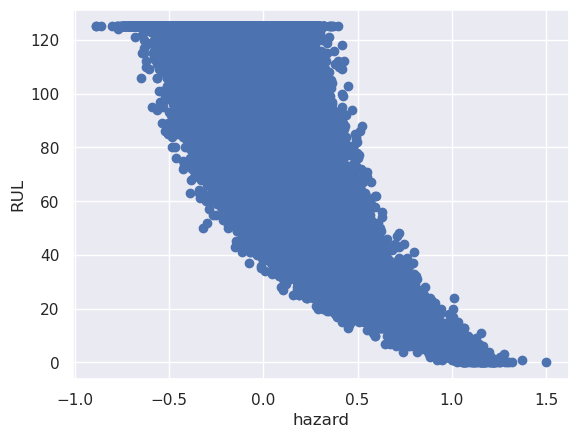

In [32]:
plt.scatter(df_hazard['hazard'], df_hazard['RUL'])
plt.xlabel('hazard')
plt.ylabel('RUL')
plt.show()

In [33]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def exponential_model(z, a, b):
    return a * np.exp(-b * z)
  
popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['RUL'])
print(popt)

[88.55861057  0.80713244]


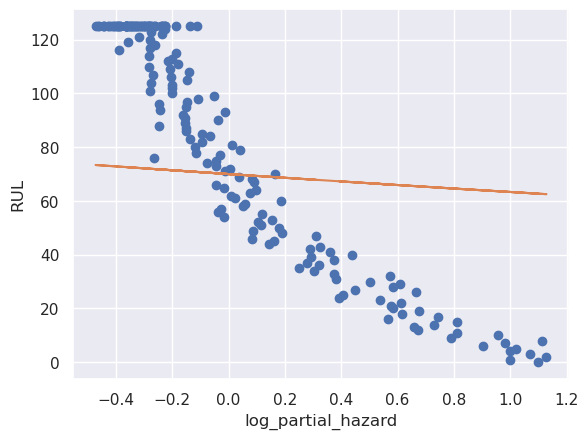

In [34]:
#Idea of fit: The line that was actually fitted is less accurate as it takes data points of all engines into account.
# check specific unit_nr
y_hat = exponential_model(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], 70, 0.1)
plt.plot(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], df_hazard.loc[df_hazard['unit_nr']==1, 'RUL'], 'o',
         df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("RUL")
plt.show()
plt.close()

In [35]:
test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [36]:
# prep test set
test = test.drop(labels=drop_labels, axis=1)
test['breakdown'] = 0
test['start'] = test['time_cycles'] - 1

# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)
evaluate(df_hazard['RUL'], y_hat, 'train')

y_pred = ctv.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt)
evaluate(y_test, y_hat)

train set RMSE:26.200901103670684, R2:0.552251211565116
test set RMSE:27.120397316520535, R2:0.5740755696863653


In [37]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train[train_cols], id_col="unit_nr", event_col='breakdown', 
         start_col='start', stop_col='time_cycles', show_progress=True)

train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['RUL'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['RUL'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(y_test, y_hat)

Iteration 1: norm_delta = 1.00314, step_size = 0.95000, ll = -363.73938, newton_decrement = 168.94519, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23297, step_size = 0.95000, ll = -196.95744, newton_decrement = 65.27103, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.74854, step_size = 0.95000, ll = -141.32406, newton_decrement = 25.30741, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.72741, step_size = 0.93100, ll = -129.43964, newton_decrement = 16.79179, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.22965, step_size = 1.00000, ll = -115.92018, newton_decrement = 1.13231, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.04043, step_size = 1.00000, ll = -114.78357, newton_decrement = 0.01240, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00056, step_size = 1.00000, ll = -114.77107, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -114.77106, newton_decrement = 0.00000, secon

Iteration 1: norm_delta = 9.24919, step_size = 0.9500, log_lik = -375.89040, newton_decrement = 147.61850, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.70384, step_size = 0.2375, log_lik = -313.76522, newton_decrement = 105.07142, seconds_since_start = 0.0
Iteration 3: norm_delta = 8.72638, step_size = 0.0772, log_lik = -298.15684, newton_decrement = 96.48921, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.74651, step_size = 0.0246, log_lik = -293.47048, newton_decrement = 94.01933, seconds_since_start = 0.0
Iteration 5: norm_delta = 8.75415, step_size = 0.0078, log_lik = -292.00388, newton_decrement = 93.25532, seconds_since_start = 0.0
Iteration 6: norm_delta = 8.75670, step_size = 0.0025, log_lik = -291.53932, newton_decrement = 93.01417, seconds_since_start = 0.1
Iteration 7: norm_delta = 8.75753, step_size = 0.0008, log_lik = -291.39162, newton_decrement = 92.93758, seconds_since_start = 0.1
Iteration 8: norm_delta = 8.75779, step_size = 0.0003, log_lik = -291.3446

/home/tomxu/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column start has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/tomxu/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<AxesSubplot:>

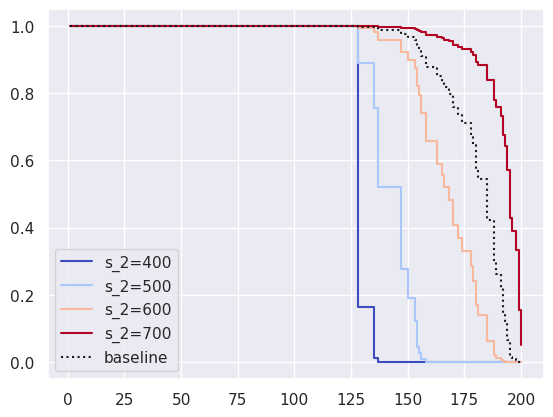

In [38]:
cph = CoxPHFitter()
cph.fit(train_censored[train_cols], duration_col='time_cycles', event_col='breakdown', show_progress=True)
cph.plot_covariate_groups('s_2', [400, 500, 600, 700], cmap='coolwarm')

<AxesSubplot:>

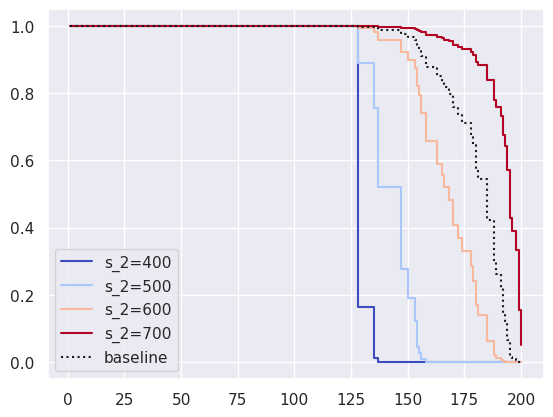

In [39]:
cph.plot_partial_effects_on_outcome(covariates="s_2", values=[400, 500, 600, 700], cmap='coolwarm')

398.92035785482676
398.87053730519625


<lifelines.WeibullAFTFitter: fitted with 18627 total observations, 18573 right-censored observations>
             duration col = 'time_cycles'
                event col = 'breakdown'
   number of observations = 18627
number of events observed = 54
           log-likelihood = -287.62
         time fit was run = 2023-05-16 16:23:57 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ s_11       -0.00       1.00       0.08            -0.16             0.15                 0.85                 1.16
        s_12        0.03       1.03       0.03            -0.02             0.09                 0.98                 1.09
        s_13       -0.14       0.87       0.25            -0.62             0.34                 0.54                 1.41
        s_14        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        s_15       -0.24       0.79       0.42            -1.07             0.60                 0.34                 1.82
        s_17       -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
        s_2        -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
        s_20        0.33       1.39       0.15             0.04             0.62                 1.04                 1.85
        s_21        0.35       1.42       0.18            -0.01             0.71                 0.99                 2.04
        s_3        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        s_4        -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
        s_7         0.06       1.06       0.03            -0.01             0.12                 0.99                 1.13
        s_8         0.13       1.14       0.19            -0.25             0.50                 0.78                 1.65
        s_9        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Intercept   5.49     242.47     504.83          -983.95           994.93                 0.00                  inf
rho_    s_11       -1.95       0.14       1.02            -3.94             0.05                 0.02                 1.05
        s_12        0.95       2.57       0.30             0.35             1.54                 1.42                 4.66
        s_13       -3.25       0.04       3.38            -9.87             3.38                 0.00                29.26
        s_14       -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
        s_15       -8.93       0.00       5.88           -20.46             2.60                 0.00                13.44
        s_17       -0.14       0.87       0.10            -0.33             0.04                 0.72                 1.04
        s_2         0.42       1.53       0.33            -0.22             1.07                 0.80                 2.91
        s_20       -0.06       0.94       1.00            -2.02             1.89                 0.13                 6.62
        s_21       -2.47       0.08       1.53            -5.48             0.53                 0.00                 1.70
        s_3         0.04       1.04       0.03            -0.02             0.09                 0.98                 1.09
        s_4        -0.04       0.96       0.03            -0.09             0.02                 0.91                 1.02
        s_7         0.47       1.60       0.34            -0.21             1.14                 0.81                 3.13
        s_8         2.93      18.73       3.30            -3.53             9.39           

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

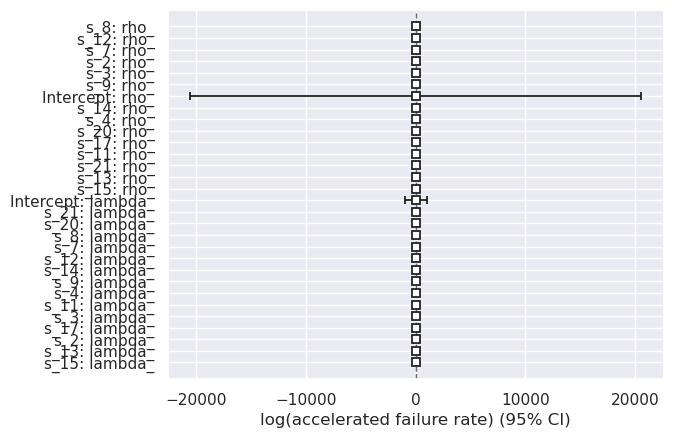

In [40]:
aft = WeibullAFTFitter()
train_cols1 = ['time_cycles'] + remaining_sensors + ['breakdown']
aft.fit(train_censored[train_cols1], duration_col='time_cycles', event_col='breakdown', ancillary=True)
print(aft.median_survival_time_)
print(aft.mean_survival_time_)
aft.print_summary()
aft.plot()

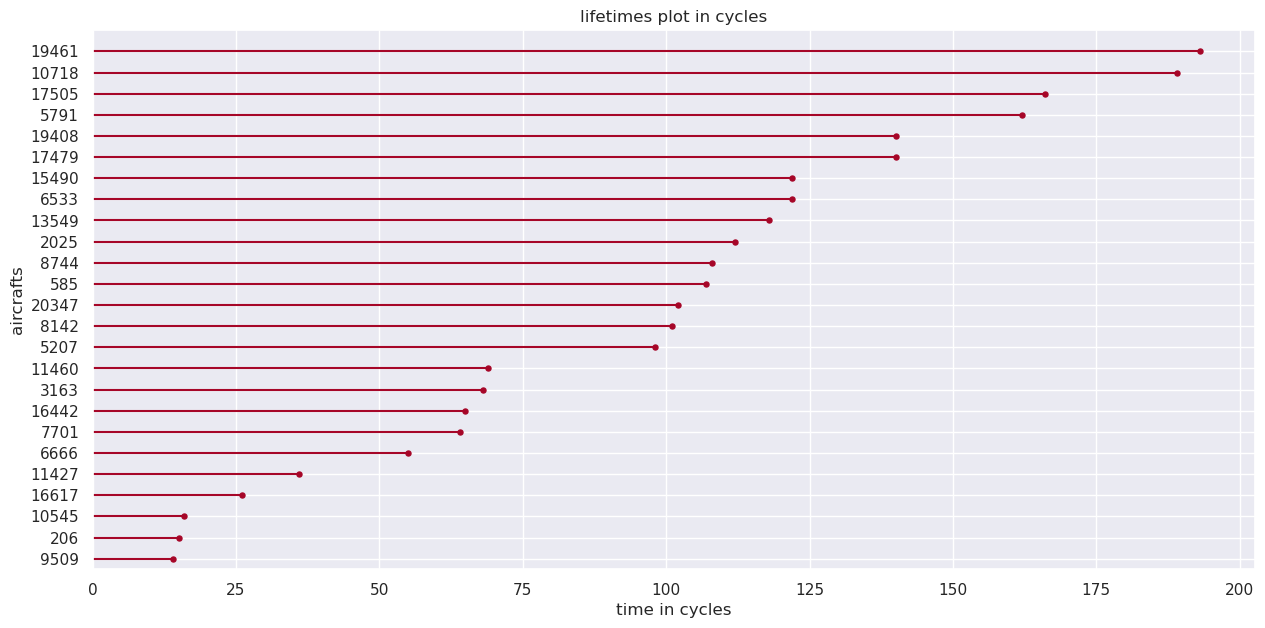

In [ ]:
# lifelines plot of the dataset to show days survived and death event occurence
df=train_censored[train_cols1].sample(25)  # random sampling of data
plt.figure(figsize=[15,7])
plot_lifetimes(df['time_cycles'])
plt.title('lifetimes plot in cycles')
plt.xlabel('time in cycles')
plt.ylabel('aircrafts')
plt.show()

<AxesSubplot: >

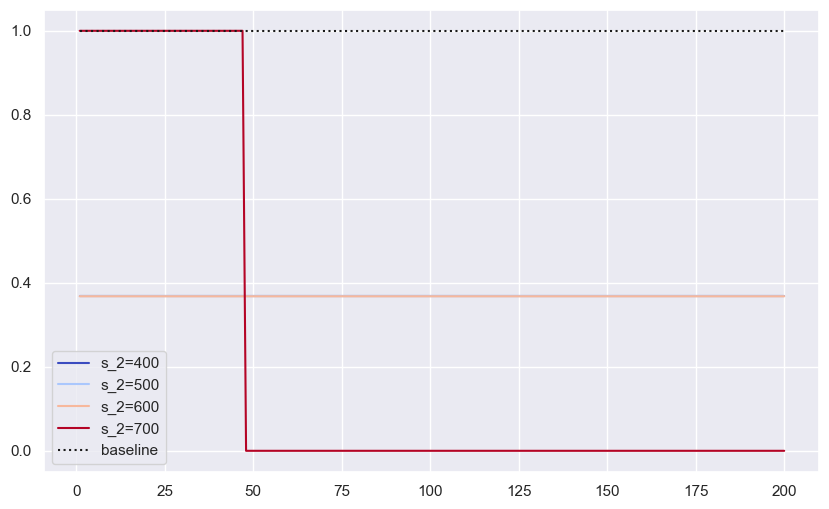

In [ ]:
plt.subplots(figsize=(10, 6))
aft.plot_partial_effects_on_outcome('s_2', range(400, 800, 100), cmap='coolwarm')

In [41]:
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations=train_censored["time_cycles"], event_observed=train_censored["breakdown"])
    # Print AIC
    print("The AIC, BIC value for", model.__class__.__name__, "are",  model.AIC_, model.BIC_)

The AIC, BIC value for WeibullFitter are 900.1564914882468 915.8212263283128
The AIC, BIC value for ExponentialFitter are 1232.4932544685887 1240.3256218886218
The AIC, BIC value for LogNormalFitter are 907.5497179557254 923.2144527957914
The AIC, BIC value for LogLogisticFitter are 900.7074346000985 916.3721694401645


In [47]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv

In [60]:
# Create a pipeline for scaling the features and fitting the Cox proportional hazards model
pipeline = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(),
)
test_censored = test[test['time_cycles'] <= cut_off].copy()
X_test = test_censored.groupby('unit_nr').last()[remaining_sensors]
y_test["breakdown"] = 1
y_array = y_test[["breakdown", "time_cycles"]]
# List of tuples
aux = [(e1, e2) for e1, e2 in y_array]
# Structured array
y_test = np.array(aux, dtype=[('breakdown', '?'), ('time_cycles', '<f8')])
X_train = train_censored[remaining_sensors]
y_train = Surv().from_dataframe("breakdown", "time_cycles", train_censored)
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# Evaluate the pipeline on the testing data
score = pipeline.score(X_test, y_test)
print(f"Concordance index: {score:.3f}")

Concordance index: 0.791
